In [107]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
desired_res = (24, 24, 24)

hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 100
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    (2, 2, 1)      # No pooling after the third stage
]

In [109]:
import os
print(os.listdir('../'))

['best_models', 'classification_knots_3d_arrays_weak_tunning', 'classification_knots_spectrum_strong_tunning', 'data_generation', 'HOPFS_L270_5e-07_test_1s']


In [110]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}
# knot_types = {
#
#     'optimized': 0,  # 6
#
#     'dennis': 1,
#
#     'trefoil_optimized': 2,
#
#
# }

knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]
knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]
# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
folder = '../HOPFS_L270_5e-07_test_1s'
#

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)
flag_print_shape = True
for knot in knots:
    # filename = f'../../../{folder}/data_{knot}.csv'
    filename = f'{folder}/data_{knot}.csv'
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]
            Nx, Ny, Nz = data_array[1]
            if flag_print_shape:
                print(Nx, Ny, Nz)
                flag_print_shape = False
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            X_list.append(dots_3d)
            # X_list.append(data_array)
            Y_list.append(knot_types[knot])


64 64 100


In [111]:
print(Y_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [112]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
print(X_np)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [

In [113]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [114]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, desired=desired_res):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x


In [115]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [116]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 24, 24, 24])
tensor([[ 0.2153,  0.1018,  0.0331,  0.1071,  0.1226, -0.0980, -0.0016,  0.0199,
          0.1932,  0.1284, -0.0347,  0.0152]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 24, 24, 24]             896
       BatchNorm3d-2       [-1, 32, 24, 24, 24]              64
              ReLU-3       [-1, 32, 24, 24, 24]               0
            Conv3d-4       [-1, 32, 24, 24, 24]          27,680
       BatchNorm3d-5       [-1, 32, 24, 24, 24]              64
              ReLU-6       [-1, 32, 24, 24, 24]               0
            Conv3d-7       [-1, 32, 24, 24, 24]          27,680
       BatchNorm3d-8       [-1, 32, 24, 24, 24]              64
              ReLU-9       [-1, 32, 24, 24, 24]               0
        MaxPool3d-10       [-1, 32, 13, 13, 13]               0
           Conv3d-11  

In [117]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [118]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:   1%|          | 1/100 [00:00<00:31,  3.18it/s]

Epoch 0 completed in 0.31 seconds
Epoch 0: Train Loss: 2.4782, Val Loss: 2.4845
Epoch 1 completed in 0.20 seconds
Epoch 1: Train Loss: 2.4266, Val Loss: 2.4854


Progress:   4%|▍         | 4/100 [00:00<00:21,  4.52it/s]

Epoch 2 completed in 0.20 seconds
Epoch 2: Train Loss: 2.3829, Val Loss: 2.4859
Epoch 3 completed in 0.21 seconds
Epoch 3: Train Loss: 2.3411, Val Loss: 2.4862


Progress:   5%|▌         | 5/100 [00:01<00:20,  4.64it/s]

Epoch 4 completed in 0.21 seconds
Epoch 4: Train Loss: 2.3080, Val Loss: 2.4867


Progress:   6%|▌         | 6/100 [00:01<00:20,  4.60it/s]

Epoch 5 completed in 0.22 seconds
Epoch 5: Train Loss: 2.2662, Val Loss: 2.4871


Progress:   7%|▋         | 7/100 [00:01<00:20,  4.63it/s]

Epoch 00007: reducing learning rate of group 0 to 2.0000e-06.
Epoch 6 completed in 0.21 seconds
Epoch 6: Train Loss: 2.2376, Val Loss: 2.4876


Progress:   9%|▉         | 9/100 [00:01<00:19,  4.67it/s]

Epoch 7 completed in 0.21 seconds
Epoch 7: Train Loss: 2.1881, Val Loss: 2.4879
Epoch 8 completed in 0.21 seconds
Epoch 8: Train Loss: 2.1956, Val Loss: 2.4880


Progress:  10%|█         | 10/100 [00:02<00:19,  4.65it/s]

Epoch 9 completed in 0.22 seconds
Epoch 9: Train Loss: 2.1939, Val Loss: 2.4881


Progress:  11%|█         | 11/100 [00:02<00:19,  4.68it/s]

Epoch 10 completed in 0.21 seconds
Epoch 10: Train Loss: 2.1888, Val Loss: 2.4882


Progress:  12%|█▏        | 12/100 [00:02<00:18,  4.66it/s]

Epoch 11 completed in 0.22 seconds
Epoch 11: Train Loss: 2.1768, Val Loss: 2.4882


Progress:  13%|█▎        | 13/100 [00:02<00:18,  4.65it/s]

Epoch 00013: reducing learning rate of group 0 to 4.0000e-07.
Epoch 12 completed in 0.22 seconds
Epoch 12: Train Loss: 2.1665, Val Loss: 2.4882


Progress:  14%|█▍        | 14/100 [00:03<00:18,  4.64it/s]

Epoch 13 completed in 0.22 seconds
Epoch 13: Train Loss: 2.1437, Val Loss: 2.4882


Progress:  15%|█▌        | 15/100 [00:03<00:18,  4.63it/s]

Epoch 14 completed in 0.22 seconds
Epoch 14: Train Loss: 2.1559, Val Loss: 2.4879


Progress:  16%|█▌        | 16/100 [00:03<00:18,  4.60it/s]

Epoch 15 completed in 0.22 seconds
Epoch 15: Train Loss: 2.1507, Val Loss: 2.4873


Progress:  17%|█▋        | 17/100 [00:03<00:17,  4.62it/s]

Epoch 16 completed in 0.21 seconds
Epoch 16: Train Loss: 2.1537, Val Loss: 2.4863


Progress:  18%|█▊        | 18/100 [00:03<00:17,  4.60it/s]

Epoch 17 completed in 0.22 seconds
Epoch 17: Train Loss: 2.1528, Val Loss: 2.4849


Progress:  19%|█▉        | 19/100 [00:04<00:17,  4.60it/s]

Epoch 18 completed in 0.22 seconds
Epoch 18: Train Loss: 2.1480, Val Loss: 2.4831


Progress:  20%|██        | 20/100 [00:04<00:17,  4.61it/s]

Epoch 19 completed in 0.22 seconds
Epoch 19: Train Loss: 2.1459, Val Loss: 2.4808


Progress:  21%|██        | 21/100 [00:04<00:17,  4.64it/s]

Epoch 20 completed in 0.21 seconds
Epoch 20: Train Loss: 2.1555, Val Loss: 2.4781


Progress:  22%|██▏       | 22/100 [00:04<00:16,  4.65it/s]

Epoch 21 completed in 0.21 seconds
Epoch 21: Train Loss: 2.1549, Val Loss: 2.4754


Progress:  23%|██▎       | 23/100 [00:05<00:16,  4.66it/s]

Epoch 22 completed in 0.21 seconds
Epoch 22: Train Loss: 2.1461, Val Loss: 2.4720


Progress:  24%|██▍       | 24/100 [00:05<00:16,  4.64it/s]

Epoch 23 completed in 0.22 seconds
Epoch 23: Train Loss: 2.1393, Val Loss: 2.4678


Progress:  25%|██▌       | 25/100 [00:05<00:16,  4.65it/s]

Epoch 24 completed in 0.21 seconds
Epoch 24: Train Loss: 2.1520, Val Loss: 2.4621


Progress:  26%|██▌       | 26/100 [00:05<00:16,  4.56it/s]

Epoch 25 completed in 0.23 seconds
Epoch 25: Train Loss: 2.1485, Val Loss: 2.4552


Progress:  27%|██▋       | 27/100 [00:05<00:15,  4.62it/s]

Epoch 26 completed in 0.21 seconds
Epoch 26: Train Loss: 2.1419, Val Loss: 2.4471


Progress:  28%|██▊       | 28/100 [00:06<00:15,  4.63it/s]

Epoch 27 completed in 0.21 seconds
Epoch 27: Train Loss: 2.1445, Val Loss: 2.4365


Progress:  29%|██▉       | 29/100 [00:06<00:15,  4.60it/s]

Epoch 28 completed in 0.22 seconds
Epoch 28: Train Loss: 2.1339, Val Loss: 2.4236


Progress:  30%|███       | 30/100 [00:06<00:15,  4.60it/s]

Epoch 29 completed in 0.22 seconds
Epoch 29: Train Loss: 2.1333, Val Loss: 2.4077


Progress:  31%|███       | 31/100 [00:06<00:14,  4.61it/s]

Epoch 30 completed in 0.22 seconds
Epoch 30: Train Loss: 2.1194, Val Loss: 2.3898


Progress:  32%|███▏      | 32/100 [00:06<00:14,  4.60it/s]

Epoch 31 completed in 0.22 seconds
Epoch 31: Train Loss: 2.1381, Val Loss: 2.3695


Progress:  33%|███▎      | 33/100 [00:07<00:14,  4.62it/s]

Epoch 32 completed in 0.21 seconds
Epoch 32: Train Loss: 2.1249, Val Loss: 2.3472


Progress:  34%|███▍      | 34/100 [00:07<00:14,  4.63it/s]

Epoch 33 completed in 0.21 seconds
Epoch 33: Train Loss: 2.1353, Val Loss: 2.3238


Progress:  35%|███▌      | 35/100 [00:07<00:14,  4.63it/s]

Epoch 34 completed in 0.22 seconds
Epoch 34: Train Loss: 2.1272, Val Loss: 2.3013


Progress:  36%|███▌      | 36/100 [00:07<00:13,  4.62it/s]

Epoch 35 completed in 0.22 seconds
Epoch 35: Train Loss: 2.1284, Val Loss: 2.2794


Progress:  37%|███▋      | 37/100 [00:08<00:13,  4.64it/s]

Epoch 36 completed in 0.21 seconds
Epoch 36: Train Loss: 2.1170, Val Loss: 2.2597


Progress:  38%|███▊      | 38/100 [00:08<00:13,  4.64it/s]

Epoch 37 completed in 0.21 seconds
Epoch 37: Train Loss: 2.1208, Val Loss: 2.2421


Progress:  39%|███▉      | 39/100 [00:08<00:13,  4.65it/s]

Epoch 38 completed in 0.21 seconds
Epoch 38: Train Loss: 2.1078, Val Loss: 2.2262


Progress:  40%|████      | 40/100 [00:08<00:12,  4.65it/s]

Epoch 39 completed in 0.21 seconds
Epoch 39: Train Loss: 2.1278, Val Loss: 2.2120


Progress:  41%|████      | 41/100 [00:08<00:12,  4.61it/s]

Epoch 40 completed in 0.22 seconds
Epoch 40: Train Loss: 2.1154, Val Loss: 2.1995


Progress:  42%|████▏     | 42/100 [00:09<00:12,  4.57it/s]

Epoch 41 completed in 0.22 seconds
Epoch 41: Train Loss: 2.1076, Val Loss: 2.1886


Progress:  43%|████▎     | 43/100 [00:09<00:12,  4.63it/s]

Epoch 42 completed in 0.21 seconds
Epoch 42: Train Loss: 2.1149, Val Loss: 2.1796


Progress:  44%|████▍     | 44/100 [00:09<00:12,  4.64it/s]

Epoch 43 completed in 0.21 seconds
Epoch 43: Train Loss: 2.1281, Val Loss: 2.1715


Progress:  46%|████▌     | 46/100 [00:10<00:11,  4.63it/s]

Epoch 44 completed in 0.22 seconds
Epoch 44: Train Loss: 2.0988, Val Loss: 2.1654
Epoch 45 completed in 0.21 seconds
Epoch 45: Train Loss: 2.1066, Val Loss: 2.1597


Progress:  47%|████▋     | 47/100 [00:10<00:11,  4.65it/s]

Epoch 46 completed in 0.21 seconds
Epoch 46: Train Loss: 2.0930, Val Loss: 2.1563


Progress:  48%|████▊     | 48/100 [00:10<00:11,  4.63it/s]

Epoch 47 completed in 0.22 seconds
Epoch 47: Train Loss: 2.1047, Val Loss: 2.1523


Progress:  49%|████▉     | 49/100 [00:10<00:11,  4.62it/s]

Epoch 48 completed in 0.22 seconds
Epoch 48: Train Loss: 2.0990, Val Loss: 2.1486


Progress:  50%|█████     | 50/100 [00:10<00:10,  4.62it/s]

Epoch 49 completed in 0.22 seconds
Epoch 49: Train Loss: 2.1043, Val Loss: 2.1454


Progress:  51%|█████     | 51/100 [00:11<00:10,  4.64it/s]

Epoch 50 completed in 0.21 seconds
Epoch 50: Train Loss: 2.0965, Val Loss: 2.1426


Progress:  52%|█████▏    | 52/100 [00:11<00:10,  4.64it/s]

Epoch 51 completed in 0.21 seconds
Epoch 51: Train Loss: 2.1228, Val Loss: 2.1392


Progress:  53%|█████▎    | 53/100 [00:11<00:10,  4.64it/s]

Epoch 52 completed in 0.22 seconds
Epoch 52: Train Loss: 2.1145, Val Loss: 2.1364


Progress:  54%|█████▍    | 54/100 [00:11<00:09,  4.64it/s]

Epoch 53 completed in 0.21 seconds
Epoch 53: Train Loss: 2.0874, Val Loss: 2.1348


Progress:  55%|█████▌    | 55/100 [00:11<00:09,  4.65it/s]

Epoch 54 completed in 0.21 seconds
Epoch 54: Train Loss: 2.0736, Val Loss: 2.1331


Progress:  56%|█████▌    | 56/100 [00:12<00:09,  4.65it/s]

Epoch 55 completed in 0.21 seconds
Epoch 55: Train Loss: 2.1020, Val Loss: 2.1319


Progress:  57%|█████▋    | 57/100 [00:12<00:09,  4.66it/s]

Epoch 56 completed in 0.21 seconds
Epoch 56: Train Loss: 2.1096, Val Loss: 2.1294


Progress:  58%|█████▊    | 58/100 [00:12<00:09,  4.66it/s]

Epoch 57 completed in 0.21 seconds
Epoch 57: Train Loss: 2.0965, Val Loss: 2.1278


Progress:  59%|█████▉    | 59/100 [00:12<00:08,  4.67it/s]

Epoch 58 completed in 0.21 seconds
Epoch 58: Train Loss: 2.0793, Val Loss: 2.1269


Progress:  60%|██████    | 60/100 [00:13<00:08,  4.61it/s]

Epoch 59 completed in 0.22 seconds
Epoch 59: Train Loss: 2.0776, Val Loss: 2.1255


Progress:  62%|██████▏   | 62/100 [00:13<00:08,  4.64it/s]

Epoch 60 completed in 0.22 seconds
Epoch 60: Train Loss: 2.0870, Val Loss: 2.1245
Epoch 61 completed in 0.21 seconds
Epoch 61: Train Loss: 2.0887, Val Loss: 2.1226


Progress:  63%|██████▎   | 63/100 [00:13<00:08,  4.60it/s]

Epoch 62 completed in 0.22 seconds
Epoch 62: Train Loss: 2.0855, Val Loss: 2.1212


Progress:  64%|██████▍   | 64/100 [00:13<00:07,  4.60it/s]

Epoch 63 completed in 0.22 seconds
Epoch 63: Train Loss: 2.0792, Val Loss: 2.1196


Progress:  65%|██████▌   | 65/100 [00:14<00:07,  4.61it/s]

Epoch 64 completed in 0.21 seconds
Epoch 64: Train Loss: 2.0821, Val Loss: 2.1178


Progress:  66%|██████▌   | 66/100 [00:14<00:07,  4.62it/s]

Epoch 65 completed in 0.21 seconds
Epoch 65: Train Loss: 2.0760, Val Loss: 2.1162


Progress:  67%|██████▋   | 67/100 [00:14<00:07,  4.64it/s]

Epoch 66 completed in 0.21 seconds
Epoch 66: Train Loss: 2.0764, Val Loss: 2.1152


Progress:  68%|██████▊   | 68/100 [00:14<00:06,  4.65it/s]

Epoch 67 completed in 0.21 seconds
Epoch 67: Train Loss: 2.0776, Val Loss: 2.1144


Progress:  69%|██████▉   | 69/100 [00:14<00:06,  4.65it/s]

Epoch 68 completed in 0.22 seconds
Epoch 68: Train Loss: 2.0719, Val Loss: 2.1127


Progress:  70%|███████   | 70/100 [00:15<00:06,  4.63it/s]

Epoch 69 completed in 0.22 seconds
Epoch 69: Train Loss: 2.0727, Val Loss: 2.1106


Progress:  71%|███████   | 71/100 [00:15<00:06,  4.62it/s]

Epoch 70 completed in 0.22 seconds
Epoch 70: Train Loss: 2.0651, Val Loss: 2.1097


Progress:  72%|███████▏  | 72/100 [00:15<00:06,  4.62it/s]

Epoch 71 completed in 0.22 seconds
Epoch 71: Train Loss: 2.0699, Val Loss: 2.1084


Progress:  73%|███████▎  | 73/100 [00:15<00:05,  4.61it/s]

Epoch 72 completed in 0.22 seconds
Epoch 72: Train Loss: 2.0695, Val Loss: 2.1066


Progress:  74%|███████▍  | 74/100 [00:16<00:05,  4.62it/s]

Epoch 73 completed in 0.21 seconds
Epoch 73: Train Loss: 2.0547, Val Loss: 2.1050


Progress:  75%|███████▌  | 75/100 [00:16<00:05,  4.63it/s]

Epoch 74 completed in 0.22 seconds
Epoch 74: Train Loss: 2.0575, Val Loss: 2.1037


Progress:  76%|███████▌  | 76/100 [00:16<00:05,  4.64it/s]

Epoch 75 completed in 0.21 seconds
Epoch 75: Train Loss: 2.0714, Val Loss: 2.1019


Progress:  77%|███████▋  | 77/100 [00:16<00:04,  4.66it/s]

Epoch 76 completed in 0.21 seconds
Epoch 76: Train Loss: 2.0612, Val Loss: 2.1008


Progress:  78%|███████▊  | 78/100 [00:16<00:04,  4.66it/s]

Epoch 77 completed in 0.21 seconds
Epoch 77: Train Loss: 2.0713, Val Loss: 2.0995


Progress:  79%|███████▉  | 79/100 [00:17<00:04,  4.65it/s]

Epoch 78 completed in 0.22 seconds
Epoch 78: Train Loss: 2.0623, Val Loss: 2.0983


Progress:  80%|████████  | 80/100 [00:17<00:04,  4.59it/s]

Epoch 79 completed in 0.22 seconds
Epoch 79: Train Loss: 2.0585, Val Loss: 2.0974


Progress:  81%|████████  | 81/100 [00:17<00:04,  4.59it/s]

Epoch 80 completed in 0.22 seconds
Epoch 80: Train Loss: 2.0460, Val Loss: 2.0983


Progress:  82%|████████▏ | 82/100 [00:17<00:03,  4.60it/s]

Epoch 81 completed in 0.22 seconds
Epoch 81: Train Loss: 2.0531, Val Loss: 2.0972


Progress:  83%|████████▎ | 83/100 [00:17<00:03,  4.60it/s]

Epoch 82 completed in 0.22 seconds
Epoch 82: Train Loss: 2.0480, Val Loss: 2.0963


Progress:  84%|████████▍ | 84/100 [00:18<00:03,  4.62it/s]

Epoch 83 completed in 0.21 seconds
Epoch 83: Train Loss: 2.0314, Val Loss: 2.0955


Progress:  85%|████████▌ | 85/100 [00:18<00:03,  4.61it/s]

Epoch 84 completed in 0.22 seconds
Epoch 84: Train Loss: 2.0669, Val Loss: 2.0934


Progress:  86%|████████▌ | 86/100 [00:18<00:03,  4.57it/s]

Epoch 85 completed in 0.22 seconds
Epoch 85: Train Loss: 2.0446, Val Loss: 2.0918


Progress:  87%|████████▋ | 87/100 [00:18<00:02,  4.56it/s]

Epoch 86 completed in 0.22 seconds
Epoch 86: Train Loss: 2.0613, Val Loss: 2.0898


Progress:  88%|████████▊ | 88/100 [00:19<00:02,  4.55it/s]

Epoch 87 completed in 0.22 seconds
Epoch 87: Train Loss: 2.0476, Val Loss: 2.0888


Progress:  89%|████████▉ | 89/100 [00:19<00:02,  4.58it/s]

Epoch 88 completed in 0.21 seconds
Epoch 88: Train Loss: 2.0499, Val Loss: 2.0870


Progress:  90%|█████████ | 90/100 [00:19<00:02,  4.58it/s]

Epoch 89 completed in 0.22 seconds
Epoch 89: Train Loss: 2.0372, Val Loss: 2.0858


Progress:  91%|█████████ | 91/100 [00:19<00:01,  4.61it/s]

Epoch 90 completed in 0.21 seconds
Epoch 90: Train Loss: 2.0442, Val Loss: 2.0841


Progress:  92%|█████████▏| 92/100 [00:19<00:01,  4.63it/s]

Epoch 91 completed in 0.21 seconds
Epoch 91: Train Loss: 2.0266, Val Loss: 2.0834


Progress:  93%|█████████▎| 93/100 [00:20<00:01,  4.64it/s]

Epoch 92 completed in 0.21 seconds
Epoch 92: Train Loss: 2.0322, Val Loss: 2.0822


Progress:  94%|█████████▍| 94/100 [00:20<00:01,  4.62it/s]

Epoch 93 completed in 0.22 seconds
Epoch 93: Train Loss: 2.0373, Val Loss: 2.0801


Progress:  95%|█████████▌| 95/100 [00:20<00:01,  4.60it/s]

Epoch 94 completed in 0.22 seconds
Epoch 94: Train Loss: 2.0387, Val Loss: 2.0790


Progress:  96%|█████████▌| 96/100 [00:20<00:00,  4.61it/s]

Epoch 95 completed in 0.22 seconds
Epoch 95: Train Loss: 2.0393, Val Loss: 2.0772


Progress:  97%|█████████▋| 97/100 [00:21<00:00,  4.62it/s]

Epoch 96 completed in 0.22 seconds
Epoch 96: Train Loss: 2.0241, Val Loss: 2.0760


Progress:  98%|█████████▊| 98/100 [00:21<00:00,  4.63it/s]

Epoch 97 completed in 0.21 seconds
Epoch 97: Train Loss: 2.0388, Val Loss: 2.0739
Epoch 98 completed in 0.21 seconds
Epoch 98: Train Loss: 2.0273, Val Loss: 2.0726


Progress: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s]

Epoch 99 completed in 0.21 seconds
Epoch 99: Train Loss: 2.0195, Val Loss: 2.0711
Total training time: 21.68 seconds


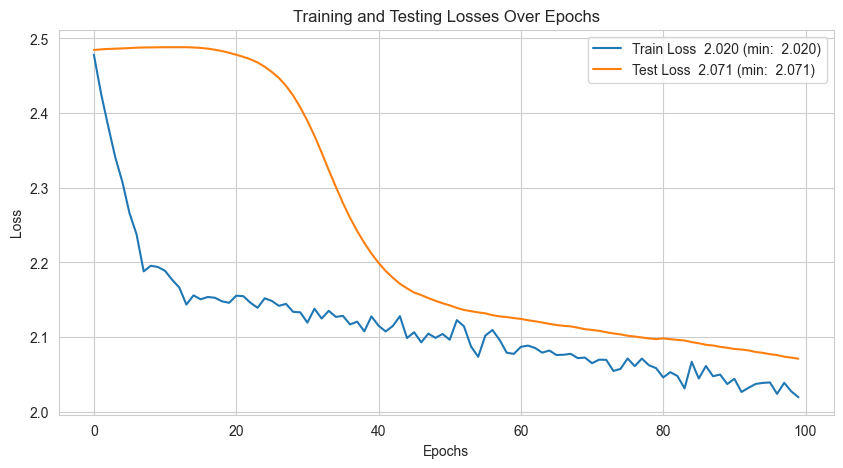

In [119]:
plot_losses(train_losses, val_losses, decimals=3)

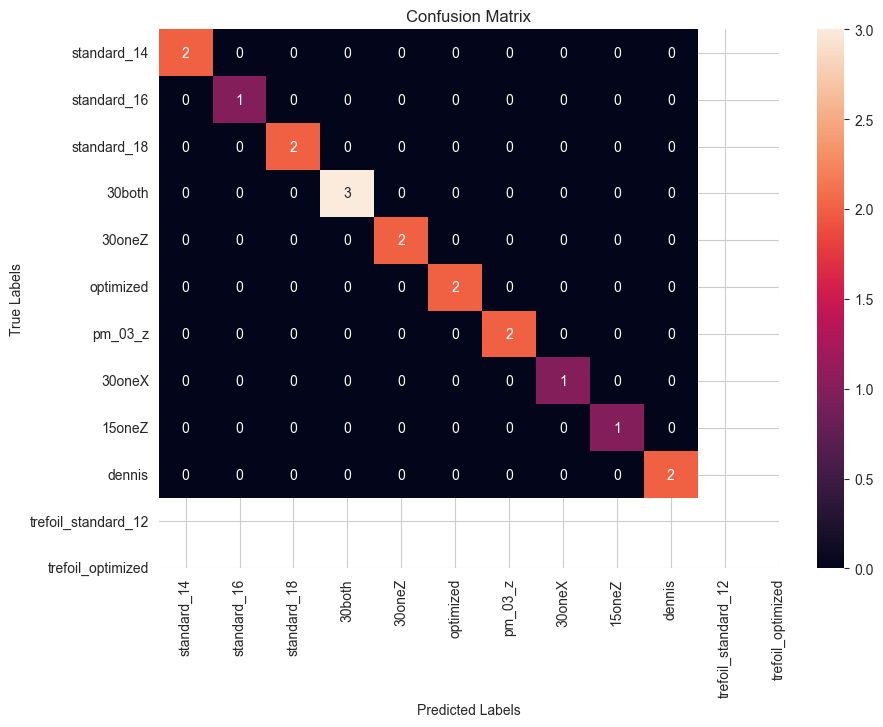

In [120]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [121]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

1.0


In [122]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 18/18
Number of correct predictions (val): 18/18


Creating the least of the weights in 2D as a basis

In [123]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'../DATA/{folder}/data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

-6 6 0 6
standard_14


FileNotFoundError: [Errno 2] No such file or directory: '..\\../HOPFS_L270_5e-07_test_1s\\standard_14.pkl'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)